# Import Libraries

In [1]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import json

import CityScapes_labels as labels

# Classes we want to predict

In [2]:
# what classes do we want to predict?
list_of_predicted_classes = ['car', 'person']
list_of_classes = list_of_predicted_classes.insert(0, '__bgr__')
cityscapes_to_new = {}
new_to_cityscapes = {}

In [3]:
list_of_predicted_classes

['__bgr__', 'car', 'person']

In [4]:
# need to relabel the classes, e.g. car from class 13 becomes 1
for idz, c in enumerate(list_of_predicted_classes[1:]):
    assert c in labels.label2id.keys()
    cityscapes_to_new[labels.label2id[c]] = idz + 1
    new_to_cityscapes[idz+1] = labels.label2id[c]

In [5]:
new_to_cityscapes

{1: 26, 2: 24}

In [6]:
cityscapes_to_new

{26: 1, 24: 2}

# Extract Bounding Boxes

In [7]:
def extract_bboxes_cityscapes(fname, list_of_correct_labels):    
    with open(fname) as f:
         cs = json.load(f)
    objects = cs['objects']
    classes = []
    bboxes = []
    # extract 
    for o in objects:
        classlabel = o['label']
        # avoid some labels
        if classlabel in list_of_predicted_classes: 
            # extract the label and convert it to integer 
            classes.append([labels.label2id[o['label']]])
            # extract the bounding box from the polygon
            x,y = zip(*o['polygon'])
            min_x, max_x = min(x), max(x)
            min_y, max_y = min(y), max(y)
            bbox = [min_x, min_y, max_x, max_y]         
            bboxes.append(bbox)
    #return a label: class of the object and bbox gt
    label = {}     
    classes = torch.tensor(classes, dtype=torch.int64)
    label['classes'] = classes
    label['bboxes'] = torch.tensor(bboxes, dtype=torch.float32)
    return label

In [8]:
path = '../../Datasets/CityScapes/gtFine_trainvaltest/gtFine/train/aachen/'

# Extract Masks for semantic segmentation

In [9]:
def extract_segmentation_mask_cityscapes(fname, list_of_predicted_labels):
    mask = np.array(Image.open(fname))
    # get rid of classes we don't need, convert them to background
    for l in np.unique(mask):        
        _l = labels.id2label[l]
        if not _l in list_of_predicted_labels:
            mask[mask==l]=0 

    # relabel the classes so that they are consecutive, 
    # e.g. 0 for bgr, 1 for car, 2 for pedestrian, etc
    _cl = np.unique(mask)
    for c in _cl[1:]:
        mask[mask==c] = cityscapes_to_new[c]

    mask = torch.tensor(mask, dtype=torch.uint8) 
    return mask


# Extract Masks for Instance Segmentation

In [10]:
# this must point to an instance mask, e.g. aachen_000096_000019_gtFine_instanceIds.png
# this will return a full image mask with all non-selected classes=0
# for mask prediction you should add the code here that identifies classes of objects
# you can add code here to extract bboxes
def extract_instance_mask_cityscapes(fname, list_of_predicted_labels):
    mask = torch.tensor(np.array(Image.open(fname)), dtype=torch.uint8)
    # get segmentation mask to find which classes to get rid of
    _fname_segment = re.sub('instanceIds', 'labelIds', fname)
    _mask_segmentation = extract_segmentation_mask_cityscapes(_fname_segment, list_of_predicted_labels)
    plt.imshow(_mask_segmentation)
    # get rid of all instances except the predicted
    mask_instances_bgr = mask*_mask_segmentation
    plt.imshow(mask_instances_bgr)
    _instances = np.unique(mask_instances_bgr)
    print(_instances)
    list_of_masks = []
    for  _m in _instances[1:]:
        _mask = torch.zeros(mask.shape, dtype = torch.uint8)
        _mask[mask_instances_bgr == _m] = 1
        #plt.imshow(_mask)
        #plt.show()    
        list_of_masks.append(_mask)

    return list_of_masks


[  0 128 130 147 148 149 150 151 152 153 154]


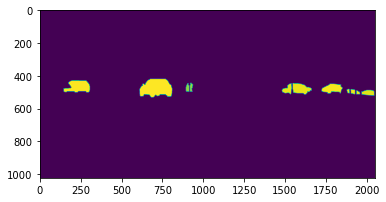

In [11]:
masks = extract_instance_mask_cityscapes(path+"aachen_000000_000019_gtFine_instanceIds.png", list_of_predicted_classes)

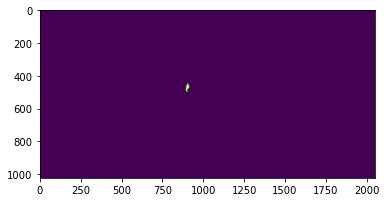

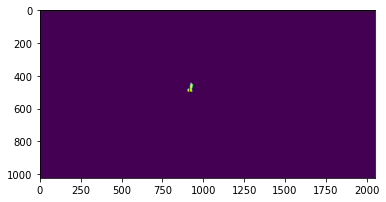

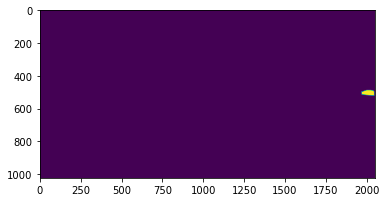

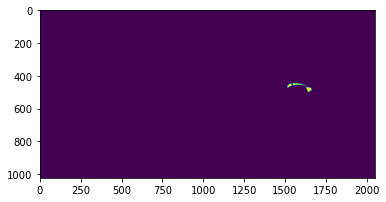

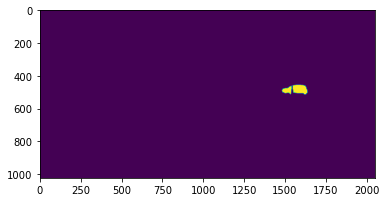

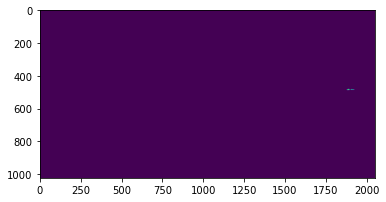

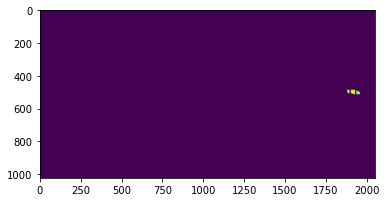

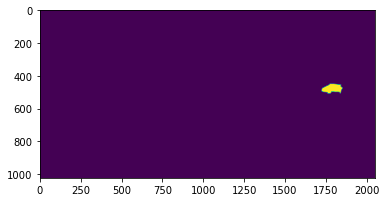

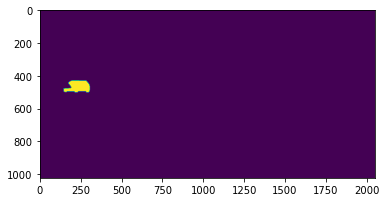

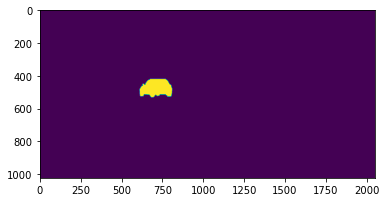

In [12]:
for mask in masks:
    plt.imshow(mask)
    plt.show()